# Import data and libraries

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


import re
import string
from wordcloud import WordCloud

from textblob import TextBlob

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import word2vec

from collections import Counter
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline

import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import Adam

import transformers
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TextClassificationPipeline)

import joblib
from tqdm import tqdm

import contractions
import shap

In [5]:
tf.compat.v1.disable_v2_behavior()

In [6]:
data = pd.read_csv("/kaggle/input/cyberbullying-dataset/twitter_parsed_dataset.csv").drop(columns=['id', 'index', "Annotation"])
data.columns = ['text', 'label']

In [7]:
data

,text,label
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0
1,@ShreyaBafna3 Now you idiots claim that people...,0.0
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0
4,#mkr No No No No No No,0.0
...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0


In [8]:
data['text'].sample(1).values[0]

'RT @PeterTownsend7: #Muslim #Islam Welcome to the Hotel Islamfornia. May check out any time but never leave. http://t.co/8vVkPH55DH http://…'

In [9]:
data['text'][0]

'@halalflaws @biebervalue @greenlinerzjm I read them in context.No change in meaning. The history of Islamic slavery. https://t.co/xWJzpSodGj'

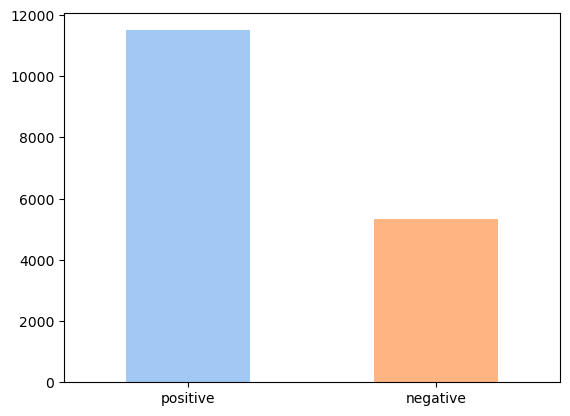

In [10]:
data['label'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))
plt.xticks([0,1],['positive', 'negative'], rotation=0);

# EDA

In [11]:
only_english = set(nltk.corpus.words.words())
def clean_text(text):
    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('#', ' ', sample) #remove hashtags
    sample = ' '.join([x for x in sample.split() if not x.startswith('@')]) # remove mentions with @
    sample = " ".join([contractions.fix(x) for x in sample.split()])  # fixes contractions like you're to you are
    sample = re.sub('[%s]' % re.escape(string.punctuation), ' ', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = " ".join(x.strip() for x in sample.split()) #strips whitespace
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

In [12]:
data['cleaned_text'] = data['text'].apply(lambda x: clean_text(str(x)))
data

,text,label,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...
4,#mkr No No No No No No,0.0,mkr no no no no no no
...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked


In [13]:
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def correct_text(text, stem=False, lemma=False, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text
    
    sample = text
    
    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    if lemma:
        sample = sample.split()
        sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
        sample = ' '.join(sample)
        
    if stem:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)
    
    if spell:
        sample = str(TextBlob(text).correct())
    
    return sample

In [14]:
data['correct_text'] = 'text'
data

,text,label,cleaned_text,correct_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,text
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,text
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...,text
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...,text
4,#mkr No No No No No No,0.0,mkr no no no no no no,text
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,text
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,text
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,text
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,text


In [15]:
count = 0
for text in tqdm(data['cleaned_text']):
    data['correct_text'][count] = correct_text(text, lemma=True)
    count +=1

  0%|          | 0/16851 [00:00<?, ?it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/nltk/corpus/util.py:80 in __load                         │
│                                                                                                  │
│    77 │   │   │   try:                                                                           │
│    78 │   │   │   │   root = nltk.data.find('{}/{}'.format(self.subdir, self.__name))            │
│    79 │   │   │   except LookupError as e:                                                       │
│ ❱  80 │   │   │   │   try: root = nltk.data.find('{}/{}'.format(self.subdir, zip_name))          │
│    81 │   │   │   │   except LookupError: raise e                                                │
│    82 │   │                                                                                      │
│    83 │   │   # Load the corpus.                                                                 │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/nltk/data.py:653 in find                                 │
│                                                                                                  │
│    650 │   msg += '\n  Searched in:' + ''.join('\n    - %r' % d for d in paths)                  │
│    651 │   sep = '*' * 70                                                                        │
│    652 │   resource_not_found = '\n%s\n%s\n%s' % (sep, msg, sep)                                 │
│ ❱  653 │   raise LookupError(resource_not_found)                                                 │
│    654                                                                                           │
│    655                                                                                           │
│    656 def retrieve(resource_url, filename=None, verbose=True):                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
LookupError: 
**********************************************************************
  Resource 'corpora/wordnet.zip/wordnet/.zip/' not found.  Please
  use the NLTK Downloader to obtain the resource:  >>>
  nltk.download()
  Searched in:
    - '/root/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

During handling of the above exception, another exception occurred:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 count = 0                                                                                    │
│   2 for text in tqdm(data['cleaned_text']):                                                      │
│ ❱ 3 │   data['correct_text'][count] = correct_text(text, lemma=True)                             │
│   4 │   count +=1                                                                                │
│   5                                                                                              │
│                                                                                                  │
│ in correct_text:34                                                                               │
│                                                                                                  │
│   31 │                                                                                           │
│   32 │   if lemma:                                                                               │
│   33 │   │   sample = sample.split()

In [ ]:
data['word_count'] = data['correct_text'].apply(lambda x: len(str(x).split(" ")))
data['char_count'] = data['correct_text'].str.len() ## this also includes spaces

In [ ]:
data

In [ ]:
plt.figure(figsize=(15,10))
data['char_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

In [ ]:
data = data[~(data['char_count'] == 0)].reset_index(drop=True)

In [ ]:
data[(data['label'] == 0)]

In [ ]:
g = str(data[data['label']== 0]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

In [ ]:
g = str(data[data['label']==1]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='black', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

In [ ]:
final_data = data.drop(columns=['text', 'cleaned_text', 'word_count', 'char_count'])
# final_data.to_csv("final_cleaned_data.csv", index=False)

In [ ]:
# final_data = pd.read_csv('final_cleaned_data.csv')
final_data

# Build Vocabulary

In [ ]:
# load doc and add to vocab
def build_vocab(vocab_obj, text):
    sample = text
    tokens = [word for word in sample.split()]
    vocab_obj.update(tokens)

def save__vocab_list(vocab, filename):
    lines = [a for a in vocab.keys()]
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w', encoding="utf-8")
    # write text
    file.write(data)
    # close file
    file.close()


In [ ]:
vocab = Counter()
for text in final_data['correct_text']:
    build_vocab(vocab, text)

In [ ]:
print(vocab.most_common(50))

In [ ]:
g = " ".join([x[0] for x in vocab.most_common(50)])

wordcloud = WordCloud(width = 800, height = 800, background_color ='black', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

In [ ]:
save__vocab_list(vocab, 'vocab.txt')

# Modeling

In [ ]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

#  define the model
def define_model(vocab_size, max_length, n_words):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Flatten(input_shape=(n_words,)))
    model.add(Dense(45, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model


In [ ]:
X = final_data['correct_text']
y = final_data['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [ ]:
X_train.fillna(" ", axis=0, inplace=True)
X_test.fillna(" ", axis=0, inplace=True)
y_train.fillna(0.0, inplace=True)
y_test.fillna(1.0, inplace=True)

In [ ]:
vocab_set = set([x for x in vocab if len(x)>2])

tokenizer = create_tokenizer(X_train.values)
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(s.split()) for s in X_train])

In [ ]:
x_train = encode_docs(tokenizer, max_length, X_train.values)
x_test = encode_docs(tokenizer, max_length, X_test.values)

In [ ]:
clf_model = define_model(vocab_size, max_length, x_train.shape[1])

In [ ]:
clf_model.fit(x_train, y_train.values, epochs=10, verbose=2, batch_size=74)

In [ ]:
clf_model.evaluate(x_train, y_train, verbose=0)[1]

In [ ]:
clf_model.evaluate(x_test, y_test, verbose=0)[1]

In [ ]:
clf_model.predict(x_test[0].reshape(1,-1))[0,0]

In [ ]:
def predict_sentiment(text, vocab=vocab_set, tokenizer=tokenizer, max_length=max_length, model=clf_model):
    line = text
    # clean review
    line = clean_text(line)
    line = correct_text(line)
    line = " ".join([word for word in line.split() if word in vocab])
    # encode and pad review
    padded = encode_docs(tokenizer, max_length, [line])
    # predict sentiment
    yhat = model.predict(padded, verbose=0)
#     print(yhat)
    # retrieve predicted percentage and label
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'


In [ ]:
predict_sentiment(final_data['correct_text'][200], vocab_set, tokenizer, max_length, clf_model)

In [ ]:
clf_model.save('clf_seq.h5')

# Explainable AI

In [ ]:
shap.initjs()

In [ ]:
samples = x_train[:100]
# session had to be manually specified


In [ ]:
explainer = shap.DeepExplainer(clf_model, np.asarray(samples))
shap_values = explainer.shap_values(x_test[:10])

In [ ]:
shap.summary_plot(shap_values, feature_names= list(vocab_set), class_names=["NEGATIVE", "POSITIVE"])

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0], 
#                 feature_names= list(vocab_set),
                feature_names= [sentence for sentence in X_test[:10].values]
               )